In [104]:
import pandas as pd
import numpy as np 
from glob import glob
import matplotlib.pyplot as plt 
import scipy.optimize as opt
from sklearn.metrics import r2_score
paths = [
    "./results/Berliner/1879",
    "./results/Figaro/1898",
    "./results/NYH/1920",
    "./results/Imparcial/1898"
]
newspapers = [path.split("/")[2] for path in paths] 
dfs = [(get_df_from_path(path),newspapers[i]) for i,path in enumerate(paths)]

In [128]:

def get_df_from_path(path):
    all_files= glob(path + "/*/*.csv")
    li = []
    for file in all_files:
        date = file.split("/")[-1].split(".")[0]
        temp_df = pd.read_csv(file)
        temp_df["Date"] = date
        li.append(temp_df)
    df = pd.concat(li, axis=0, ignore_index=True)
    df = df[(df["Length"] > 0) & (df["Ratio"] > 0 )& (df["Ratio"]<1)]
    return df

def plot_dfs_hist(dfs):
    plt.figure(figsize=(8, 6))

    for (df,name) in dfs:
        arr = df["Ratio"]
        weights = np.ones_like(arr)/float(len(arr))
        plt.hist(x = arr, bins = 20, alpha = 0.4, label = name, weights = weights)
    plt.title("Distribution of word ratio per newspaper")
    plt.xlabel("Word ratio")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig('histo.png')
    plt.show()


def plot_dfs_wr(dfs):

    def f(x,a,b): 
        if isinstance(x,pd.Series) or isinstance(x,np.ndarray):
            y = []
            for elem in x:
               y.append( a*np.log(elem) + b if elem != 0 else b)
            return y
        else:
            return a*np.log(x) + b if x != 0 else b
    
    for (df, name )in dfs:
        x = df["Length"]
        y = df["Ratio"]
        a, _ = opt.curve_fit(f,x,y)
        y_pred = f(x,a[0], a[1])
        r2 = r2_score(y,y_pred)
        plt.figure(figsize=(8, 6))

        plt.scatter(x = x, y = y,label = name, alpha = 0.3)
        x = np.linspace(0, max(x), num=5000)
        plt.plot(x, f(x,a[0], a[1]), c = "red")
        plt.title(f"Word ratio w.r.t. document length for the newspaper {name}")
        plt.xlabel("Word ratio")
        plt.ylabel("Length")
        plt.legend(["Text Block", "regression: $y = log({:0.3f}*x) + {:0.3}".format(a[0], a[1])])
        plt.savefig(f'dwr{name}.png')
        print(r2)
        plt.show()

# path = "./results/NYH/1920"
# df = get_df_from_path(path)
# df

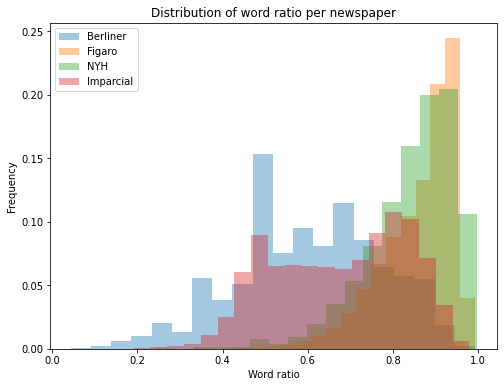

In [129]:

# plot_dfs_wr(dfs)
plot_dfs_hist(dfs)

In [4]:
path = "./results/NYT/1920"
df = get_df_from_path(path)
bad = df[(df["Ratio"] < 0.6) & (df["Length"] > 20)][["Text", 'Date']]
bad.to_csv("bad_ocr.txt", index= False)